## Amazon Review Clustering

In [1]:
import pandas as pd
import numpy as np
import random
import json
import nltk
from gensim.utils import tokenize
from gensim.parsing.porter import PorterStemmer
import pattern
from gensim.utils import lemmatize
from gensim import models, similarities
from gensim.corpora.dictionary import Dictionary

### Load Data

#### Random Sample 10% of Revew Data

In [2]:
data = open("Home_and_Kitchen.json", "r")
sample_data = []
for d in data:
    choice = random.choices([0, 1], weights=(90, 10), k = 1)[0]
    if choice == 1:
        sample_data.append(d.strip())
data.close()

In [3]:
with open("Home_and_Kitchen_10.json", 'w') as f:
    for j in sample_data:
        f.write(j + '\n')

In [4]:
df = pd.read_json("Home_and_Kitchen_10.json", orient='records', lines=True)
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,5,5,True,"09 20, 2009",AV24U7RX2TX2X,0681795107,Eden A. Millecchi,This is hands down the best travel mug I have ...,this mug rocks,1253404800,NaN,NaN
1,3,NaN,True,"02 26, 2013",A9IWX56NDNJKS,0681795107,Patricia Hanley,"Convenient shape, good handle; but doesn't hol...",Timolino PAB-46GRE travel mug,1361836800,{'Color:': ' Red'},NaN
2,5,4,True,"01 21, 2013",AVE60P73ELI2P,0681795107,danielc74,LOVE these cups! My husband has hand one for 1...,Travel Mug,1358726400,{'Color:': ' Brushed Stainless'},NaN
3,4,NaN,True,"11 12, 2011",A22JPQM47XD7Q8,0681795107,Gashauler,Overall it is a nice mug. it is easy to use an...,Nice mug,1321056000,{'Color:': ' Black'},NaN
4,1,11,False,"05 25, 2008",AT12C3M9O2EUY,0752873016,Keen Bean,Aliens visit the little Gaulish village we kno...,If you love Asterix - don't read this,1211673600,{'Format:': ' Paperback'},NaN


Remove unnecessary columns.

In [5]:
df.drop(['reviewTime', 'reviewerID', 'style', 'reviewerName', 'unixReviewTime', 'image'], axis=1, inplace=True)

#### Objective: Find topics of concerns about products of Tools & Home Improvement category among verified and negative (overall <3) reviews.

Keep only verified and overall <3 review.

In [6]:
df = df[df['verified'] == True]
df.head()

,overall,vote,verified,asin,reviewText,summary
0,5,5,True,0681795107,This is hands down the best travel mug I have ...,this mug rocks
1,3,NaN,True,0681795107,"Convenient shape, good handle; but doesn't hol...",Timolino PAB-46GRE travel mug
2,5,4,True,0681795107,LOVE these cups! My husband has hand one for 1...,Travel Mug
3,4,NaN,True,0681795107,Overall it is a nice mug. it is easy to use an...,Nice mug
5,3,NaN,True,0752873016,This one is OK but not up to early standards. ...,Wit is falling


In [7]:
df = df[df['overall'] <= 3]
df.head()

,overall,vote,verified,asin,reviewText,summary
1,3,NaN,True,0681795107,"Convenient shape, good handle; but doesn't hol...",Timolino PAB-46GRE travel mug
5,3,NaN,True,0752873016,This one is OK but not up to early standards. ...,Wit is falling
10,1,6,True,089886531X,The Amazon title just says Good Bugs/Bad Bugs....,Title Misleading
43,3,NaN,True,1890560243,"needs to be more simple for kids to grasp, esp...",Three Stars
59,3,NaN,True,1933064129,"Since the book was titled, ""The Great American...",Somewhat Disappointing


In [8]:
df.drop('verified', axis=1, inplace=True)

Use metadata to filter data and keep only reviews for Tools & Home Improvement products.

In [11]:
meta = open("meta_Home_and_Kitchen.json", "r")
subMeta = []
for d in meta:
    if 'Tools & Home Improvement' in d:
        subMeta.append(d.strip())
meta.close()

In [16]:
with open("meta_Home_and_Kitchen_10.json", 'w') as f:
    for j in subMeta:
        f.write(j + '\n')

In [17]:
meta = pd.read_json("meta_Home_and_Kitchen_10.json", orient='records', lines=True)
meta.head()

,category,tech1,description,fit,title,also_buy,image,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,details
0,"[Home & Kitchen, Home Dcor, Home Dcor Accents,...","class=""a-keyvalue prodDetTable"" role=""present...","[Great for any Man Cave, this two-sided novelt...",,Man Cave: Restricted Area sign 11in x 7.5in,[],[],,Bendon,"[Two-sided Man Cave decor sign, Measures 7.5"" ...","[>#1,076,821 in Tools & Home Improvement (See ...",[],Tools & Home Improvement,,"March 15, 2015",,163346217X,NaN
1,"[Home & Kitchen, Home Dcor, Kids' Room Dcor, L...","class=""a-keyvalue prodDetTable"" role=""present...",[The Harry Potter LUMOS Book Light brings the ...,,LightWedge Harry Potter LUMOS Book Light,[],[https://images-na.ssl-images-amazon.com/image...,,Lightwedge,[Patented LightWedge technology directs light ...,"[>#708,607 in Tools & Home Improvement (See to...","[1223027090, B07DKF415M, B07DKG6BY8, B01J3PAVS...",Tools & Home Improvement,,"April 12, 2005",,1932836438,NaN
2,"[Home & Kitchen, Home Dcor, Kids' Room Dcor, W...",,"[Better than wallpaper, wall stickers are a pe...",,Monkey Hanging Over Trees Nursery/Kids' Room W...,[],[https://images-na.ssl-images-amazon.com/image...,,Hyundae Sheet,"[Peel & stick; No paint, no tools, and no hass...","[>#763,876 in Tools & Home Improvement (See To...",[],Amazon Home,,,$35.00,710402686X,{}
3,"[Home & Kitchen, Seasonal Dcor, Seasonal Light...","class=""a-keyvalue prodDetTable"" role=""present...",[Each Kit Includes:[1 X Pre-installed 3' Stand...,,CBconcept 120VLR65FT-BLUE 120V 2-Wire 1/2-Inch...,[],[https://images-na.ssl-images-amazon.com/image...,,CBconcept,"[[Energy saving - 0.4 Watts per foot , Round 1...","[>#1,578,369 in Tools & Home Improvement (See ...",[],Tools & Home Improvement,,"June 14, 2010",,7300075975,{}
4,"[Home & Kitchen, Heating, Cooling & Air Qualit...",,"[The Lasko digital ceramic tower heater, with ...",,Lasko 5160 Ceramic Tower Heater with Remote Co...,"[B074MX8VNR, B00002NCJI, B00N1XCCNQ, B07CTKG9Q...",[https://images-na.ssl-images-amazon.com/image...,,Lasko,[23-Inch ceramic tower heater with patented co...,[>#46 in Home & Kitchen (See Top 100 in Home &...,[],Amazon Home,"class=""a-bordered a-horizontal-stripes a-spa...",,$53.99,7300019196,{}


In [19]:
meta = meta[meta['main_cat'] == 'Tools & Home Improvement']

In [23]:
meta = meta[['asin']]

In [26]:
tool_data = df[df['asin'].isin(meta['asin'])]

### Clean Data

Remove punctuations.

In [27]:
tool_data['cleanText'] = tool_data['reviewText'].str.replace(r'[^\w\s]+', '')

/var/folders/jv/24lkdph54q14lprtpmb40sxw0000gn/T/ipykernel_5295/4019695372.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  tool_data['cleanText'] = tool_data['reviewText'].str.replace(r'[^\w\s]+', '')
/var/folders/jv/24lkdph54q14lprtpmb40sxw0000gn/T/ipykernel_5295/4019695372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tool_data['cleanText'] = tool_data['reviewText'].str.replace(r'[^\w\s]+', '')


In [28]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wantienchiang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
from nltk.corpus import stopwords

Remove stopwords.

In [30]:
STOPWORDS = set(stopwords.words('english'))

In [31]:
tool_data.cleanText = tool_data.cleanText.fillna("")

/var/folders/jv/24lkdph54q14lprtpmb40sxw0000gn/T/ipykernel_5295/262095301.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tool_data.cleanText = tool_data.cleanText.fillna("")


In [32]:
def remove_stopwords(text):
    return " ".join([word for word in str(text).lower().split() if word not in STOPWORDS])

In [33]:
tool_data.cleanText = tool_data.cleanText.apply(lambda text: remove_stopwords(text))
tool_data.head()

/var/folders/jv/24lkdph54q14lprtpmb40sxw0000gn/T/ipykernel_5295/3819860612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tool_data.cleanText = tool_data.cleanText.apply(lambda text: remove_stopwords(text))


,overall,vote,asin,reviewText,summary,cleanText
685,3,3,B0000224M6,It wasn't bad enough for us to return. The la...,Bent lamp shade,wasnt bad enough us return lamp shade dented b...
693,1,NaN,B00002N5H5,I purchased this light recently. I removed it ...,Disappointed,purchased light recently removed package insta...
698,1,2,B00002N5H5,Avoid purchasing this Fluorescent Counter Ligh...,"For your own good, skip it",avoid purchasing fluorescent counter light pos...
2188,2,NaN,B00002NC69,although I cross-checked the model of my wet-d...,poor fit,although crosschecked model wetdry van fit ite...
2378,3,NaN,B00002ND41,Not an exact fit for my Craftsman Vac.,Three Stars,exact fit craftsman vac


In [434]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

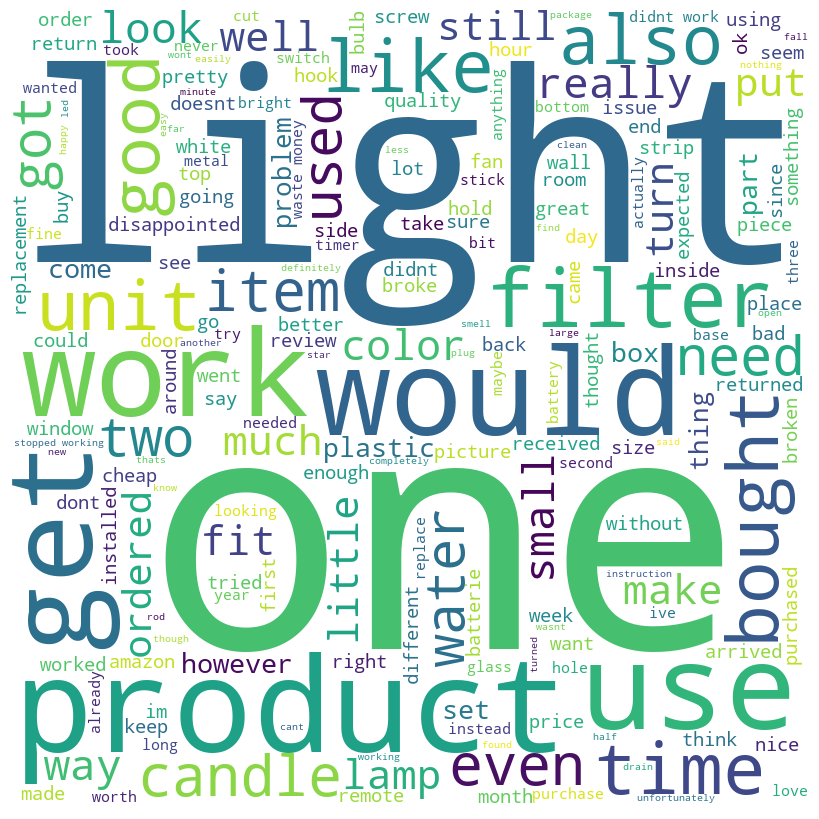

In [435]:
comment_words = ''

for val in tool_data.cleanText:
    val = str(val)
	tokens = val.split()
	for i in range(len(tokens)):
		tokens[i] = tokens[i].lower()
	
	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
				background_color ='white',
				stopwords = STOPWORDS,
				min_font_size = 10).generate(comment_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

Tokenize data.

In [34]:
tokenizedText = [list(tokenize(text)) for text in tool_data.cleanText]

In [35]:
tokenizedText[0]

['wasnt',
 'bad',
 'enough',
 'us',
 'return',
 'lamp',
 'shade',
 'dented',
 'back',
 'near',
 'seam',
 'part',
 'facing',
 'wall',
 'also',
 'bend',
 'stand',
 'near',
 'light',
 'bulb',
 'shade',
 'tilted',
 'could',
 'see',
 'light',
 'bulb',
 'side',
 'able',
 'tweak',
 'product',
 'enough',
 'easier',
 'keep',
 'return',
 'cute',
 'lamp',
 'though']

In [39]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/wantienchiang/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Lemmatize data.

In [37]:
t = [" ".join(text) for text in tokenizedText]

In [42]:
nltk.download('omw-1.4')
lemmatized_texts = [list(lemmatize(text)) for text in t]

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/wantienchiang/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [43]:
lemmatized_texts[0]

[b'wasnt/VB',
 b'bad/JJ',
 b'enough/JJ',
 b'return/NN',
 b'lamp/NN',
 b'shade/NN',
 b'dent/VB',
 b'back/RB',
 b'near/JJ',
 b'seam/NN',
 b'part/NN',
 b'face/VB',
 b'wall/NN',
 b'also/RB',
 b'bend/VB',
 b'stand/NN',
 b'light/JJ',
 b'bulb/NN',
 b'shade/NN',
 b'tilted/NN',
 b'see/VB',
 b'light/JJ',
 b'bulb/NN',
 b'side/NN',
 b'able/JJ',
 b'tweak/NN',
 b'product/NN',
 b'enough/RB',
 b'easier/RB',
 b'keep/VB',
 b'return/VB',
 b'cute/JJ',
 b'lamp/NN']

In [44]:
dictionary = Dictionary(lemmatized_texts)
corpus = [dictionary.doc2bow(text) for text in lemmatized_texts]

### Train LDA Model

In [51]:
from gensim.models import CoherenceModel

In [183]:
def show_topic_word(n, m, d):
    new_topic_kw = []
    for i in range(n):
        top10 = np.argsort(m.get_topics()[i])[-10:]
        new_topic_kw.append([d[j] for j in top10])
    new_df_topic_kw = pd.DataFrame(new_topic_kw)
    new_df_topic_kw.columns = ['Word ' + str(i) for i in range(new_df_topic_kw.shape[1])]
    new_df_topic_kw.index = ['Topic ' + str(i) for i in range(new_df_topic_kw.shape[0])]
    return new_df_topic_kw

In [186]:
def cal_coherence(corpus, d, m):
    t = [[d.id2token[t] for t, f in bow] for bow in corpus]
    cm = CoherenceModel(model=m, texts=t, dictionary=d, coherence='c_v')
    coherence_lda = cm.get_coherence()
    print('Coherence Score: ', coherence_lda)

In [333]:
num_topics = 5
model = models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=10, workers=4, dtype=np.float64, random_state=0)

### Evaluate Model

Top 10 words in each topic.

In [334]:
show_topic_word(5, model, dictionary)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,fit/JJ,well/RB,quality/NN,look/VB,box/NN,product/NN,get/VB,make/VB,lamp/NN,unit/NN
Topic 1,go/VB,money/NN,item/NN,buy/VB,work/VB,get/VB,product/NN,filter/NN,time/NN,water/NN
Topic 2,day/NN,plastic/NN,buy/VB,even/RB,set/NN,use/NN,product/NN,work/VB,make/VB,light/NN
Topic 3,buy/VB,come/VB,dont/VB,didnt/VB,work/VB,candle/NN,battery/NN,get/VB,light/NN,work/NN
Topic 4,go/VB,month/NN,get/VB,work/VB,water/NN,buy/VB,product/NN,good/JJ,look/VB,filter/NN


Coherence score.

In [335]:
cal_coherence(corpus, dictionary, model)

Coherence Score:  0.5622167636046624


### Optimize Model

#### Try using bigrams to train.

In [292]:
bigram = models.Phrases(tokenizedText)

In [293]:
bigram_mod = models.phrases.Phraser(bigram)

In [294]:
data_bigram = [bigram_mod[i] for i in tokenizedText]

In [336]:
bi_t = [" ".join(text) for text in data_bigram]
bi_lemmatized_texts = [list(lemmatize(text)) for text in bi_t]
bi_lemmatized_texts[0]

[b'wasnt/VB',
 b'bad/JJ',
 b'enough/JJ',
 b'return/NN',
 b'lamp/NN',
 b'shade/NN',
 b'dent/VB',
 b'back/RB',
 b'near/JJ',
 b'seam/NN',
 b'part/NN',
 b'face/VB',
 b'wall/NN',
 b'also/RB',
 b'bend/VB',
 b'stand/NN',
 b'light_bulb/JJ',
 b'shade/NN',
 b'tilted/NN',
 b'see/VB',
 b'light_bulb/JJ',
 b'side/NN',
 b'able/JJ',
 b'tweak/NN',
 b'product/NN',
 b'enough/RB',
 b'easier/RB',
 b'keep/VB',
 b'return/VB',
 b'cute/JJ',
 b'lamp/NN']

In [337]:
dictionary1 = Dictionary(bi_lemmatized_texts)
corpus1 = [dictionary1.doc2bow(text) for text in bi_lemmatized_texts]

#### Create an additional stopword list with low TF-IDF score.

In [338]:
bi_tfidf_model = models.TfidfModel(corpus1)
bi_low_tfidf_words = sorted(bi_tfidf_model[corpus1[0]], key=lambda e: e[1])[:15]
for word_index, score in bi_low_tfidf_words:
    print(f'{dictionary1[word_index]}   \tindex: {word_index}\ttf-idf: {score:.2f}')

product/NN   	index: 16	tf-idf: 0.07
also/RB   	index: 1	tf-idf: 0.09
return/VB   	index: 18	tf-idf: 0.10
keep/VB   	index: 11	tf-idf: 0.10
return/NN   	index: 17	tf-idf: 0.10
part/NN   	index: 15	tf-idf: 0.11
see/VB   	index: 20	tf-idf: 0.11
wall/NN   	index: 26	tf-idf: 0.11
bad/JJ   	index: 3	tf-idf: 0.11
side/NN   	index: 22	tf-idf: 0.11
back/RB   	index: 2	tf-idf: 0.12
able/JJ   	index: 0	tf-idf: 0.13
wasnt/VB   	index: 27	tf-idf: 0.13
enough/RB   	index: 9	tf-idf: 0.13
enough/JJ   	index: 8	tf-idf: 0.14


In [302]:
bi_added_stop = [dictionary1[word_index] for word_index, score in bi_low_tfidf_words]

Remove stopwords.

In [339]:
bi_lemmatized_text1 = [[w for w in text if w.decode() not in bi_added_stop] for text in bi_lemmatized_texts]
bi_lemmatized_text1[0]

[b'lamp/NN',
 b'shade/NN',
 b'dent/VB',
 b'near/JJ',
 b'seam/NN',
 b'face/VB',
 b'bend/VB',
 b'stand/NN',
 b'light_bulb/JJ',
 b'shade/NN',
 b'tilted/NN',
 b'light_bulb/JJ',
 b'tweak/NN',
 b'easier/RB',
 b'cute/JJ',
 b'lamp/NN']

Create a new dictionary without extremes.

In [341]:
bi_dictionary = Dictionary(bi_lemmatized_text1)
bi_dictionary.filter_extremes(no_below=20, no_above=0.7)

In [344]:
bi_new_corpus = [bi_dictionary.doc2bow(text) for text in bi_lemmatized_text1]

#### Try using only nouns to train.

In [345]:
nn = [[w for w in row if w[-2:] == b'NN'] for row in bi_lemmatized_text1]
nn[0]

[b'lamp/NN',
 b'shade/NN',
 b'seam/NN',
 b'stand/NN',
 b'shade/NN',
 b'tilted/NN',
 b'tweak/NN',
 b'lamp/NN']

In [346]:
dictionaryN = Dictionary(nn)
corpusN = [dictionaryN.doc2bow(text) for text in nn]

In [347]:
modelN = models.LdaMulticore(corpusN, num_topics=num_topics, id2word=dictionaryN, passes=10, workers=4, dtype=np.float64)

In [348]:
show_topic_word(5, modelN, dictionaryN)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,turn/NN,problem/NN,day/NN,battery/NN,use/NN,window/NN,time/NN,light/NN,unit/NN,candle/NN
Topic 1,work/NN,picture/NN,replacement/NN,piece/NN,filter/NN,candle/NN,screw/NN,one/NN,item/NN,box/NN
Topic 2,light/NN,piece/NN,water/NN,hook/NN,bulb/NN,hour/NN,hole/NN,use/NN,time/NN,door/NN
Topic 3,wire/NN,bulb/NN,time/NN,way/NN,set/NN,color/NN,battery/NN,lamp/NN,light/NN,work/NN
Topic 4,work/NN,year/NN,plug/NN,plastic/NN,quality/NN,month/NN,use/NN,water/NN,filter/NN,light/NN


In [349]:
cal_coherence(corpusN, dictionaryN, modelN)

Coherence Score:  0.3589098767882205


#### Try increasing topic numbers.

In [350]:
bi_new_model = models.LdaMulticore(bi_new_corpus, num_topics=5, id2word=bi_dictionary, passes=10, workers=4, dtype=np.float64, random_state=0)

In [351]:
show_topic_word(5, bi_new_model, bi_dictionary)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,buy/VB,item/NN,fall/VB,used/VB,look/VB,price/NN,strip/NN,battery/NN,break/VB,light/NN
Topic 1,go/VB,used/VB,say/VB,really/RB,still/RB,small/JJ,get/VB,buy/VB,water/NN,filter/NN
Topic 2,day/NN,come/VB,time/NN,use/NN,get/VB,go/VB,month/NN,work/VB,candle/NN,light/NN
Topic 3,order/VB,expect/VB,set/NN,color/NN,buy/VB,unit/NN,work/VB,work/NN,light/NN,get/VB
Topic 4,screw/NN,get/VB,box/NN,way/NN,plastic/NN,work/NN,door/NN,piece/NN,use/NN,make/VB


In [352]:
cal_coherence(bi_new_corpus, bi_dictionary, bi_new_model)

Coherence Score:  0.5725592870708125


In [353]:
bi_new_model1 = models.LdaMulticore(bi_new_corpus, num_topics=7, id2word=bi_dictionary, passes=10, workers=4, dtype=np.float64, random_state=0)
show_topic_word(7, bi_new_model1, bi_dictionary)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,didnt/VB,look/VB,even/RB,order/VB,need/VB,unit/NN,strip/NN,price/NN,battery/NN,light/NN
Topic 1,problem/NN,dont/VB,still/RB,good/JJ,say/VB,get/VB,small/JJ,buy/VB,water/NN,filter/NN
Topic 2,remote/JJ,time/NN,get/VB,day/NN,use/NN,month/NN,go/VB,work/VB,candle/NN,light/NN
Topic 3,candle/NN,screw/NN,set/NN,color/NN,unit/NN,expect/VB,work/VB,work/NN,get/VB,light/NN
Topic 4,used/VB,piece/NN,fit/JJ,hour/NN,well/RB,box/NN,work/NN,way/NN,use/NN,make/VB
Topic 5,plastic/NN,used/VB,work/NN,go/VB,look/VB,use/NN,small/JJ,piece/NN,get/VB,door/NN
Topic 6,month/NN,hook/NN,come/VB,look/VB,bulb/NN,buy/VB,lamp/NN,really/RB,get/VB,break/VB


In [354]:
cal_coherence(bi_new_corpus, bi_dictionary, bi_new_model1)

Coherence Score:  0.5690487594474494


In [360]:
bi_new_model2 = models.LdaMulticore(bi_new_corpus, num_topics=10, id2word=bi_dictionary, passes=10, workers=4, dtype=np.float64, random_state=0)
show_topic_word(10, bi_new_model2, bi_dictionary)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,item/NN,quality/NN,used/VB,order/VB,battery/NN,fall/VB,hook/NN,break/VB,price/NN,light/NN
Topic 1,install/VB,system/NN,good/JJ,come/VB,really/RB,get/VB,small/JJ,buy/VB,water/NN,filter/NN
Topic 2,candle/NN,set/NN,day/NN,get/VB,use/NN,month/NN,disappoint/VB,go/VB,work/VB,light/NN
Topic 3,set/NN,instruction/NN,size/NN,buy/VB,work/NN,light/NN,good/JJ,expect/VB,screw/NN,get/VB
Topic 4,used/VB,box/NN,fit/JJ,plastic/NN,cute/JJ,use/NN,lamp/NN,work/NN,way/NN,make/VB
Topic 5,knife/NN,small/JJ,used/VB,give/VB,plastic/NN,time/NN,use/NN,get/VB,door/NN,piece/NN
Topic 6,doesnt/VB,come/VB,lamp/NN,month/NN,look/VB,buy/VB,really/RB,bulb/NN,get/VB,break/VB
Topic 7,time/NN,last/JJ,im/VB,purchase/VB,need/VB,used/VB,get/VB,unit/NN,didnt/VB,window/NN
Topic 8,room/NN,box/NN,still/RB,look/VB,get/VB,use/NN,light/NN,fan/NN,make/VB,unit/NN
Topic 9,work/VB,go/VB,buy/VB,dont/VB,remote/JJ,battery/NN,turn/VB,work/NN,candle/NN,light/NN


In [361]:
cal_coherence(bi_new_corpus, bi_dictionary, bi_new_model2)

Coherence Score:  0.5695310252219118


#### Try changing alpha.

In [368]:
bi_new_model_1 = models.LdaMulticore(bi_new_corpus, num_topics=5, id2word=bi_dictionary, alpha=0.5, passes=10, workers=4, dtype=np.float64, random_state=0)
show_topic_word(5, bi_new_model_1, bi_dictionary)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,even/RB,hook/NN,strip/NN,lamp/NN,doesnt/VB,price/NN,look/VB,light/NN,battery/NN,break/VB
Topic 1,dont/VB,say/VB,really/RB,good/JJ,still/RB,get/VB,small/JJ,buy/VB,water/NN,filter/NN
Topic 2,disappoint/VB,remote/JJ,day/NN,use/NN,go/VB,time/NN,candle/NN,month/NN,work/VB,light/NN
Topic 3,set/NN,candle/NN,go/VB,unit/NN,work/VB,expect/VB,color/NN,light/NN,work/NN,get/VB
Topic 4,fit/JJ,screw/NN,box/NN,work/NN,plastic/NN,way/NN,door/NN,use/NN,piece/NN,make/VB


In [369]:
cal_coherence(bi_new_corpus, bi_dictionary, bi_new_model_1)

Coherence Score:  0.5591115443780175


In [370]:
bi_new_model_1 = models.LdaMulticore(bi_new_corpus, num_topics=5, id2word=bi_dictionary, alpha=0.7, passes=10, workers=4, dtype=np.float64, random_state=0)
show_topic_word(5, bi_new_model_1, bi_dictionary)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,hook/NN,even/RB,strip/NN,doesnt/VB,price/NN,look/VB,lamp/NN,light/NN,battery/NN,break/VB
Topic 1,dont/VB,say/VB,still/RB,good/JJ,really/RB,get/VB,small/JJ,buy/VB,water/NN,filter/NN
Topic 2,set/NN,use/NN,get/VB,day/NN,candle/NN,go/VB,time/NN,month/NN,work/VB,light/NN
Topic 3,go/VB,box/NN,buy/VB,expect/VB,work/VB,candle/NN,color/NN,light/NN,work/NN,get/VB
Topic 4,screw/NN,box/NN,fit/JJ,work/NN,plastic/NN,way/NN,door/NN,use/NN,piece/NN,make/VB


In [371]:
cal_coherence(bi_new_corpus, bi_dictionary, bi_new_model_1)

Coherence Score:  0.5703303787196852


In [372]:
bi_new_model_1 = models.LdaMulticore(bi_new_corpus, num_topics=5, id2word=bi_dictionary, alpha=0.85, passes=10, workers=4, dtype=np.float64, random_state=0)
show_topic_word(5, bi_new_model_1, bi_dictionary)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,put/VB,even/RB,strip/NN,price/NN,doesnt/VB,look/VB,lamp/NN,light/NN,break/VB,battery/NN
Topic 1,come/VB,still/RB,say/VB,good/JJ,really/RB,get/VB,small/JJ,buy/VB,water/NN,filter/NN
Topic 2,remote/JJ,day/NN,set/NN,get/VB,go/VB,time/NN,candle/NN,month/NN,work/VB,light/NN
Topic 3,expect/VB,go/VB,work/VB,box/NN,buy/VB,candle/NN,color/NN,light/NN,work/NN,get/VB
Topic 4,get/VB,box/NN,fit/JJ,plastic/NN,work/NN,way/NN,door/NN,piece/NN,use/NN,make/VB


In [373]:
cal_coherence(bi_new_corpus, bi_dictionary, bi_new_model_1)

Coherence Score:  0.55031553472249


In [382]:
bi_new_model1_1 = models.LdaMulticore(bi_new_corpus, num_topics=7, id2word=bi_dictionary, alpha=0.7, passes=10, workers=4, dtype=np.float64, random_state=0)
show_topic_word(7, bi_new_model1_1, bi_dictionary)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,tape/NN,order/VB,well/RB,doesnt/VB,even/RB,strip/NN,unit/NN,price/NN,light/NN,battery/NN
Topic 1,dont/VB,get/VB,problem/NN,small/JJ,good/JJ,say/VB,still/RB,buy/VB,water/NN,filter/NN
Topic 2,year/NN,use/NN,time/NN,set/NN,day/NN,go/VB,month/NN,candle/NN,work/VB,light/NN
Topic 3,go/VB,unit/NN,expect/VB,candle/NN,light/NN,box/NN,screw/NN,color/NN,work/NN,get/VB
Topic 4,even/RB,material/NN,im/VB,hour/NN,fit/JJ,box/NN,work/NN,use/NN,way/NN,make/VB
Topic 5,large/JJ,microwave/NN,use/NN,fan/NN,plastic/NN,window/NN,small/JJ,get/VB,door/NN,piece/NN
Topic 6,money/NN,replace/VB,hook/NN,look/VB,buy/VB,bulb/NN,lamp/NN,get/VB,break/VB,really/RB


In [383]:
cal_coherence(bi_new_corpus, bi_dictionary, bi_new_model1_1)

Coherence Score:  0.5713911137870599


In [384]:
bi_new_model1_2 = models.LdaMulticore(bi_new_corpus, num_topics=7, id2word=bi_dictionary, alpha=0.8, passes=10, workers=4, dtype=np.float64, random_state=0)
show_topic_word(7, bi_new_model1_2, bi_dictionary)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,look/VB,tape/NN,doesnt/VB,even/RB,well/RB,strip/NN,price/NN,unit/NN,light/NN,battery/NN
Topic 1,dont/VB,get/VB,problem/NN,small/JJ,still/RB,good/JJ,say/VB,buy/VB,water/NN,filter/NN
Topic 2,use/NN,year/NN,time/NN,month/NN,day/NN,go/VB,set/NN,candle/NN,work/VB,light/NN
Topic 3,expect/VB,buy/VB,go/VB,candle/NN,light/NN,color/NN,work/NN,box/NN,screw/NN,get/VB
Topic 4,material/NN,even/RB,im/VB,hour/NN,fit/JJ,box/NN,work/NN,use/NN,way/NN,make/VB
Topic 5,time/NN,microwave/NN,use/NN,plastic/NN,fan/NN,window/NN,small/JJ,get/VB,door/NN,piece/NN
Topic 6,light/NN,hook/NN,month/NN,look/VB,buy/VB,bulb/NN,lamp/NN,really/RB,get/VB,break/VB


In [385]:
cal_coherence(bi_new_corpus, bi_dictionary, bi_new_model1_2)

Coherence Score:  0.5779041821452839


In [386]:
bi_new_model1_3 = models.LdaMulticore(bi_new_corpus, num_topics=7, id2word=bi_dictionary, alpha=1.0, passes=10, workers=4, dtype=np.float64, random_state=0)
show_topic_word(7, bi_new_model1_3, bi_dictionary)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,used/VB,look/VB,doesnt/VB,even/RB,well/RB,strip/NN,price/NN,unit/NN,light/NN,battery/NN
Topic 1,work/VB,still/RB,small/JJ,problem/NN,get/VB,say/VB,good/JJ,buy/VB,water/NN,filter/NN
Topic 2,remote/JJ,plug/NN,get/VB,time/NN,year/NN,go/VB,set/NN,work/VB,candle/NN,light/NN
Topic 3,take/VB,color/NN,light/NN,item/NN,buy/VB,go/VB,work/NN,box/NN,get/VB,screw/NN
Topic 4,hour/NN,light/NN,im/VB,pretty/RB,even/RB,box/NN,work/NN,use/NN,way/NN,make/VB
Topic 5,time/NN,microwave/NN,window/NN,fan/NN,use/NN,plastic/NN,small/JJ,get/VB,door/NN,piece/NN
Topic 6,hook/NN,light/NN,look/VB,buy/VB,month/NN,bulb/NN,lamp/NN,really/RB,break/VB,get/VB


In [387]:
cal_coherence(bi_new_corpus, bi_dictionary, bi_new_model1_3)

Coherence Score:  0.5828895782032534


In [374]:
bi_new_model2_1 = models.LdaMulticore(bi_new_corpus, num_topics=10, id2word=bi_dictionary, alpha=0.5, passes=10, workers=4, dtype=np.float64, random_state=0)
show_topic_word(10, bi_new_model2_1, bi_dictionary)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,well/RB,didnt/VB,doesnt/VB,used/VB,didnt_work/NN,fall/VB,order/VB,light/NN,price/NN,battery/NN
Topic 1,handle/VB,try/VB,get/VB,problem/NN,still/RB,small/JJ,good/JJ,buy/VB,water/NN,filter/NN
Topic 2,timer/NN,go/VB,disappoint/VB,set/NN,time/NN,use/NN,day/NN,month/NN,work/VB,light/NN
Topic 3,seem/VB,instruction/NN,wrong/JJ,much/JJ,job/NN,size/NN,set/NN,expect/VB,screw/NN,get/VB
Topic 4,im/VB,pretty/RB,well/RB,cute/JJ,use/NN,hour/NN,quality/NN,fit/JJ,way/NN,make/VB
Topic 5,crack/VB,come/VB,get/VB,time/NN,microwave/NN,small/JJ,plastic/NN,use/NN,door/NN,piece/NN
Topic 6,last/VB,money/NN,hook/NN,buy/VB,look/VB,lamp/NN,bulb/NN,get/VB,really/RB,break/VB
Topic 7,used/VB,seller/NN,never/RB,put/VB,purchase/VB,im/VB,get/VB,need/VB,order/NN,window/NN
Topic 8,definitely/RB,receive/VB,make/VB,look/VB,fan/NN,issue/NN,one/NN,want/VB,picture/NN,unit/NN
Topic 9,even/RB,remote/JJ,dont/VB,box/NN,go/VB,color/NN,turn/VB,work/NN,candle/NN,light/NN


In [375]:
cal_coherence(bi_new_corpus, bi_dictionary, bi_new_model2_1)

Coherence Score:  0.5401915784452546


In [376]:
bi_new_model2_2 = models.LdaMulticore(bi_new_corpus, num_topics=10, id2word=bi_dictionary, alpha=0.7, passes=10, workers=4, dtype=np.float64, random_state=0)
show_topic_word(10, bi_new_model2_2, bi_dictionary)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,already/RB,doesnt/VB,replace/VB,didnt/VB,well/RB,used/VB,order/VB,price/NN,light/NN,battery/NN
Topic 1,try/VB,handle/VB,still/RB,small/JJ,problem/NN,get/VB,good/JJ,buy/VB,water/NN,filter/NN
Topic 2,remote/JJ,timer/NN,month/NN,day/NN,plug/NN,time/NN,candle/NN,set/NN,work/VB,light/NN
Topic 3,review/NN,size/NN,buy/VB,instruction/NN,fit/JJ,box/NN,expect/VB,item/NN,get/VB,screw/NN
Topic 4,power/NN,get/VB,material/NN,fit/JJ,im/VB,box/NN,pretty/RB,use/NN,way/NN,make/VB
Topic 5,crack/VB,come/VB,time/NN,get/VB,use/NN,microwave/NN,plastic/NN,small/JJ,door/NN,piece/NN
Topic 6,last/VB,hook/NN,month/NN,buy/VB,look/VB,lamp/NN,bulb/NN,really/RB,get/VB,break/VB
Topic 7,long/JJ,seller/NN,never/RB,im/VB,purchase/VB,need/VB,put/VB,order/NN,get/VB,window/NN
Topic 8,seem/VB,one/NN,light/NN,first/JJ,make/VB,say/VB,fan/NN,picture/NN,issue/NN,unit/NN
Topic 9,wire/NN,even/RB,box/NN,dont/VB,go/VB,color/NN,turn/VB,candle/NN,work/NN,light/NN


In [377]:
cal_coherence(bi_new_corpus, bi_dictionary, bi_new_model2_2)

Coherence Score:  0.5463876841502235


In [378]:
bi_new_model2_3 = models.LdaMulticore(bi_new_corpus, num_topics=10, id2word=bi_dictionary, alpha=0.35, passes=10, workers=4, dtype=np.float64, random_state=0)
show_topic_word(10, bi_new_model2_3, bi_dictionary)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,look/VB,replace/VB,item/NN,hook/NN,order/VB,didnt_work/NN,fall/VB,light/NN,battery/NN,price/NN
Topic 1,leak/NN,try/VB,good/JJ,get/VB,still/RB,problem/NN,small/JJ,buy/VB,water/NN,filter/NN
Topic 2,come/VB,time/NN,set/NN,disappoint/VB,day/NN,use/NN,go/VB,month/NN,work/VB,light/NN
Topic 3,job/NN,much/JJ,light/NN,seem/VB,size/NN,buy/VB,set/NN,screw/NN,expect/VB,get/VB
Topic 4,well/RB,plastic/NN,fit/JJ,cute/JJ,used/VB,use/NN,hour/NN,quality/NN,way/NN,make/VB
Topic 5,used/VB,nice/JJ,small/JJ,give/VB,time/NN,plastic/NN,use/NN,get/VB,door/NN,piece/NN
Topic 6,money/NN,doesnt/VB,come/VB,buy/VB,look/VB,get/VB,lamp/NN,bulb/NN,really/RB,break/VB
Topic 7,seller/NN,never/RB,used/VB,purchase/VB,unit/NN,im/VB,get/VB,didnt/VB,need/VB,window/NN
Topic 8,use/NN,issue/NN,say/VB,make/VB,look/VB,fan/NN,one/NN,want/VB,picture/NN,unit/NN
Topic 9,bright/JJ,dont/VB,color/NN,go/VB,remote/JJ,box/NN,turn/VB,work/NN,candle/NN,light/NN


In [379]:
cal_coherence(bi_new_corpus, bi_dictionary, bi_new_model2_3)

Coherence Score:  0.5651803400190074


In [256]:
bi_new_model2 = models.LdaMulticore(bi_new_corpus, num_topics=5, id2word=bi_dictionary, alpha=0.5, eta=0.1, passes=10, workers=4, dtype=np.float64)

In [257]:
show_topic_word(5, bi_new_model2, bi_dictionary)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,problem/NN,come/VB,buy/VB,thing/NN,good/JJ,get/VB,unit/NN,water/NN,make/VB,filter/NN
Topic 1,candle/NN,work/VB,really/RB,look/VB,buy/VB,light/NN,battery/NN,item/NN,dont/VB,get/VB
Topic 2,break/VB,make/VB,work/VB,get/VB,box/NN,use/NN,come/VB,remote/JJ,buy/VB,candle/NN
Topic 3,strand/NN,work/VB,small/JJ,go/VB,lamp/NN,bulb/NN,color/NN,buy/VB,work/NN,light/NN
Topic 4,strip/NN,window/NN,unit/NN,hook/NN,used/VB,great/JJ,water/NN,filter/NN,door/NN,get/VB


In [258]:
cal_coherence(bi_new_corpus, bi_dictionary, bi_new_model2)

Coherence Score:  0.523658097910636


In [259]:
bi_new_model3 = models.LdaMulticore(bi_new_corpus, num_topics=7, id2word=bi_dictionary, alpha=0.5, eta=0.1, passes=10, workers=4, dtype=np.float64)
show_topic_word(7, bi_new_model3, bi_dictionary)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,time/NN,go/VB,cheap/JJ,window/NN,expect/VB,make/VB,much/JJ,item/NN,get/VB,door/NN
Topic 1,unit/NN,work/NN,look/VB,try/VB,even/RB,get/VB,use/NN,work/VB,buy/VB,light/NN
Topic 2,look/VB,color/NN,hook/NN,come/VB,bright/JJ,dont/VB,money/NN,say/VB,get/VB,work/NN
Topic 3,candle/NN,buy/VB,set/NN,dont/VB,use/NN,go/VB,small/JJ,really/RB,get/VB,light/NN
Topic 4,work/VB,look/VB,fan/NN,used/VB,come/VB,plug/NN,make/VB,good/JJ,get/VB,unit/NN
Topic 5,used/VB,come/VB,never/RB,buy/VB,candle/NN,break/VB,go/VB,work/VB,month/NN,battery/NN
Topic 6,use/NN,time/NN,piece/NN,item/NN,good/JJ,receive/VB,buy/VB,lamp/NN,water/NN,filter/NN


In [260]:
cal_coherence(bi_new_corpus, bi_dictionary, bi_new_model3)

Coherence Score:  0.5209625781396146


Try finding a neares neighbor using the best model.

In [430]:
def topics_to_vector(topics):
    vector = np.zeros(7)
    for index, score in topics:
        vector[index] = score
    return vector

print('Summary: ', tool_data['summary'].iloc[0])
print(tool_data['reviewText'].iloc[0])
print('\n\n')

# Conver to a vector and find nearest neighbors.
min_dist = 1e9
nearest_neighbor = -1
topic_vector = topics_to_vector(bi_new_model1_3.get_document_topics(bi_new_corpus[0]))
for ix, doc in enumerate(bi_new_corpus[1:], start=1):
    doc_vector = topics_to_vector(model.get_document_topics(doc))
    dist = np.linalg.norm(topic_vector - doc_vector)
    if dist < min_dist:
        min_dist = dist
        nearest_neighbor = ix
  
print('Nearest neighbor: ')
print('Summary: ', tool_data['summary'].iloc[nearest_neighbor])
print(tool_data['reviewText'].iloc[nearest_neighbor])

Summary:  Bent lamp shade
It wasn't bad enough for us to return.  The lamp shade was dented but it's on the back near the seam, so we just have that part facing the wall.  Also we had to bend the stand near the light bulb.  The shade was tilted so you could see the light bulb from the side.  We were able to tweak the product enough that it was easier to keep than return.  It's a very cute lamp though!



Nearest neighbor: 
Summary:  Great Concept, Almost Great Execution
Living in NYC during the summer can be dreadful without an air conditioner.  I've always wanted my apartment to be ice cold when I get home from work, so you can imagine my excitement when I first heard of Quirky's Aros.  Unfortunately, Quirky may have moved a little too fast in bringing this product to market--

Pros: the air conditioner does what air conditioners are meant to do--cools down rooms.  This one does that quite well in fact--8000 btu is enough energy to cool a pretty sizable space (roughly 350 sqft).  It a

#### Find the dominant topic for each review using the best model.

Revised Model.

In [455]:
def find_dominant_topic(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    sent_topics_df = pd.concat([sent_topics_df, texts], axis=1)
    return(sent_topics_df)


df_topic_text = find_dominant_topic(bi_new_model1_3, bi_new_corpus, tool_data.reviewText.reset_index()['reviewText'])


# Show
df_topic_text.head(10)

/var/folders/jv/24lkdph54q14lprtpmb40sxw0000gn/T/ipykernel_5295/278803600.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/jv/24lkdph54q14lprtpmb40sxw0000gn/T/ipykernel_5295/278803600.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Dominant_Topic,Perc_Contribution,Topic_Keywords,reviewText
0,6,0.3166,"get/VB, break/VB, really/RB, lamp/NN, bulb/NN,...",It wasn't bad enough for us to return. The la...
1,2,0.3799,"light/NN, candle/NN, work/VB, set/NN, go/VB, y...",I purchased this light recently. I removed it ...
2,2,0.3257,"light/NN, candle/NN, work/VB, set/NN, go/VB, y...",Avoid purchasing this Fluorescent Counter Ligh...
3,4,0.3265,"make/VB, way/NN, use/NN, work/NN, box/NN, even...",although I cross-checked the model of my wet-d...
4,3,0.2031,"screw/NN, get/VB, box/NN, work/NN, go/VB, buy/...",Not an exact fit for my Craftsman Vac.
5,4,0.1953,"make/VB, way/NN, use/NN, work/NN, box/NN, even...",They areaway over priced
6,3,0.2639,"screw/NN, get/VB, box/NN, work/NN, go/VB, buy/...",I purchased this mostly because it was the onl...
7,1,0.1711,"filter/NN, water/NN, buy/VB, good/JJ, say/VB, ...",Good
8,5,0.6058,"piece/NN, door/NN, get/VB, small/JJ, plastic/N...",It's pretty good. It sharpens blades to a poin...
9,5,0.2301,"piece/NN, door/NN, get/VB, small/JJ, plastic/N...",I used something similar before that worked bu...


Initial Model.

In [476]:
o_text = find_dominant_topic(model, corpus, tool_data.reviewText.reset_index()['reviewText'])

o_text.head(10)

/var/folders/jv/24lkdph54q14lprtpmb40sxw0000gn/T/ipykernel_5295/278803600.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/jv/24lkdph54q14lprtpmb40sxw0000gn/T/ipykernel_5295/278803600.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Dominant_Topic,Perc_Contribution,Topic_Keywords,reviewText
0,0,0.6662,"unit/NN, lamp/NN, make/VB, get/VB, product/NN,...",It wasn't bad enough for us to return. The la...
1,2,0.5397,"light/NN, make/VB, work/VB, product/NN, use/NN...",I purchased this light recently. I removed it ...
2,1,0.3565,"water/NN, time/NN, filter/NN, product/NN, get/...",Avoid purchasing this Fluorescent Counter Ligh...
3,4,0.9591,"filter/NN, look/VB, good/JJ, product/NN, buy/V...",although I cross-checked the model of my wet-d...
4,4,0.8374,"filter/NN, look/VB, good/JJ, product/NN, buy/V...",Not an exact fit for my Craftsman Vac.
5,2,0.4054,"light/NN, make/VB, work/VB, product/NN, use/NN...",They areaway over priced
6,0,0.5948,"unit/NN, lamp/NN, make/VB, get/VB, product/NN,...",I purchased this mostly because it was the onl...
7,4,0.5944,"filter/NN, look/VB, good/JJ, product/NN, buy/V...",Good
8,0,0.8044,"unit/NN, lamp/NN, make/VB, get/VB, product/NN,...",It's pretty good. It sharpens blades to a poin...
9,1,0.6526,"water/NN, time/NN, filter/NN, product/NN, get/...",I used something similar before that worked bu...


#### Look at the top 5 reviews with the highest percentage contribution to the topic.

In [468]:
show_topic_word(7, bi_new_model1_3, bi_dictionary)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,used/VB,look/VB,doesnt/VB,even/RB,well/RB,strip/NN,price/NN,unit/NN,light/NN,battery/NN
Topic 1,work/VB,still/RB,small/JJ,problem/NN,get/VB,say/VB,good/JJ,buy/VB,water/NN,filter/NN
Topic 2,remote/JJ,plug/NN,get/VB,time/NN,year/NN,go/VB,set/NN,work/VB,candle/NN,light/NN
Topic 3,take/VB,color/NN,light/NN,item/NN,buy/VB,go/VB,work/NN,box/NN,get/VB,screw/NN
Topic 4,hour/NN,light/NN,im/VB,pretty/RB,even/RB,box/NN,work/NN,use/NN,way/NN,make/VB
Topic 5,time/NN,microwave/NN,window/NN,fan/NN,use/NN,plastic/NN,small/JJ,get/VB,door/NN,piece/NN
Topic 6,hook/NN,light/NN,look/VB,buy/VB,month/NN,bulb/NN,lamp/NN,really/RB,break/VB,get/VB


In [477]:
show_topic_word(5, model, dictionary)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,fit/JJ,well/RB,quality/NN,look/VB,box/NN,product/NN,get/VB,make/VB,lamp/NN,unit/NN
Topic 1,go/VB,money/NN,item/NN,buy/VB,work/VB,get/VB,product/NN,filter/NN,time/NN,water/NN
Topic 2,day/NN,plastic/NN,buy/VB,even/RB,set/NN,use/NN,product/NN,work/VB,make/VB,light/NN
Topic 3,buy/VB,come/VB,dont/VB,didnt/VB,work/VB,candle/NN,battery/NN,get/VB,light/NN,work/NN
Topic 4,go/VB,month/NN,get/VB,work/VB,water/NN,buy/VB,product/NN,good/JJ,look/VB,filter/NN


#### The raw review texts for each topic.

Revised Model.

In [463]:
topic6 = df_topic_text[df_topic_text['Dominant_Topic'] == 6].sort_values(by='Perc_Contribution', ascending=False)

In [464]:
for i in range(5):
    print(topic6['reviewText'].iloc[i] + '\n')

I was given a similar log basket by friends when I was living in France, and absolutely LOVED it, so handy for getting wood from the shed to the fireplace and looked fine standing in a corner.
Sad to say, this is an inferior version, and absolutely NOT cheap!!  (The French one cost about 35)  This one is much flimsier, and the lining is not really convenient as it isn't waxed or otherwise weatherproofed in any way so gets dirty immediately.  My major beef is the front balancing peg, which fell off as soon as I wheeled the basket across the floor.  Tried to glue it back with heavy-duty glue, but it fell right off again, so am going to have to nail/screw it on, which means getting right down into the bottom of the basket !  The handle also is just bamboo, so I'm not sure how it will hold up to hauling basketfuls of logs.
Otherwise it's attractive enough to look at.  But I'm disappointed, truly.

These shower hooks are of inferior quality.  They didn't stay hooked together, and I am handi

Initial Model.

In [480]:
topic0_o = o_text[o_text['Dominant_Topic'] == 0].sort_values(by='Perc_Contribution', ascending=False)

In [481]:
for i in range(5):
    print(topic0_o['reviewText'].iloc[i] + '\n')

I have a Frigidaire over the range microwave, model GLMV169DBC.  This door is the correct OEM replacement part for it.  However; the manufacture changed the configuration of the door.  The replacement does not have the small plastic piece, referred to as the "door stop", located under the top hinge. So while removing this piece and the old door is a breeze, installing the new one "not so much".  No installation instructions come with the replacement door and from what I was able to determine, Frigidaire doesn't have any.  I finally found a appliance repair site that had these door replacement instructions:  1. Place the bottom door peg in the bottom hinge hole;  2.  Insert the upper hinge in the upper door opening;  3. Aline the upper hinge pin hole with the upper door pin;  4.  Push/hold the door up as high as it will go while keeping the lower peg in the hinge hole;  5.  Use a flat head screw driver, putty knife or knife and slide it under the peg, but on top of the hinge, use some f

Review of other topics based on the revised model.

In [465]:
topic5 = df_topic_text[df_topic_text['Dominant_Topic'] == 5].sort_values(by='Perc_Contribution', ascending=False)

In [466]:
for i in range(5):
    print(topic5['reviewText'].iloc[i] + '\n')

I have a Frigidaire over the range microwave, model GLMV169DBC.  This door is the correct OEM replacement part for it.  However; the manufacture changed the configuration of the door.  The replacement does not have the small plastic piece, referred to as the "door stop", located under the top hinge. So while removing this piece and the old door is a breeze, installing the new one "not so much".  No installation instructions come with the replacement door and from what I was able to determine, Frigidaire doesn't have any.  I finally found a appliance repair site that had these door replacement instructions:  1. Place the bottom door peg in the bottom hinge hole;  2.  Insert the upper hinge in the upper door opening;  3. Aline the upper hinge pin hole with the upper door pin;  4.  Push/hold the door up as high as it will go while keeping the lower peg in the hinge hole;  5.  Use a flat head screw driver, putty knife or knife and slide it under the peg, but on top of the hinge, use some f

In [469]:
topic4 = df_topic_text[df_topic_text['Dominant_Topic'] == 4].sort_values(by='Perc_Contribution', ascending=False)
for i in range(5):
    print(topic4['reviewText'].iloc[i] + '\n')

Warning! Things are way, way smaller than they appear! This micro-lock is the right size for building furniture in a moderate doll house, that is it. It is pretty, but oh-so-very-tiny! The nails are about 3/8th of an inch long! If you drop one, you'll never even hear it fall, leave alone find it again. They have no strength to hold up any serious cabinet door, even a small one. I wanted to use this to hold in place a picture frame, which I installed to serve as a stained glass front for a light in the upper part of a closed book shelf. I need to be able to open that part should the light bulb inside ever need to be replaced. This lock would not even hold up itself with those flimsy dwarf-nails! There is no way to replace the nails with screws, as there are no such tiny screws to be found, and the holes in the lock cannot be enlarged, since it is made of metal. Anyhow, if one pierced larger holes, that would leave nothing of a lock at all! So if you are not building doll hose furniture,

In [470]:
topic3 = df_topic_text[df_topic_text['Dominant_Topic'] == 3].sort_values(by='Perc_Contribution', ascending=False)
for i in range(5):
    print(topic3['reviewText'].iloc[i] + '\n')

I have never written a review where I wished I could give the item no stars.  This rack is worth about $9.99, not the over $100 I paid!  Seriously, I have seen better quality products at Walmart.  First, it is not "solid steel" construction.  It is partially some metal (which easily dents and bends - probably aluminum) and the connectors and decorative knobs are PLASTIC!  Second, the instructions are difficult and skip steps.  I am extremely capable at putting items together, and have built whole bookcases from raw wood, so I knew what I was doing and I was at least able to figure out what they wanted me to do.  That did not even frustrate me much because I could figure it out and, even though the materials were clearly shoddy, I was hopeful that the stand would not look too cheap when completed because it was the look I wanted for the bathroom.  But, the last step required me to use four screws that were supposed to be all the same size but were actually each a little different length

In [471]:
topic2 = df_topic_text[df_topic_text['Dominant_Topic'] == 2].sort_values(by='Perc_Contribution', ascending=False)
for i in range(5):
    print(topic2['reviewText'].iloc[i] + '\n')

I purchased about 20 sets of these 50cm (approx. 20" long) for residential use. This year I placed 12 sets in a 30-foot tall tree that had all the branches wrapped in red lights. I own a boom truck, so being to place them in a tall tree makes for a beautiful effect. Overall the look is very unique and stunning, and we received lots of visitors and compliments. I actually plan on doubling the amount of these "snowfall" tubes in the tree next year.

THE GOOD:

1.  The effect is really, really nice. Last year I suspended all 20 sets under our 15' x 20' pergola, and it created a very cool effect. When you first plug them in, all the sets "drip" in unison from top to bottom, but over the course of several minutes, each tube begins to drip at it's own pace, creating a completely random pattern.

2.  The warm LED light is is bright enough to be plenty visible, but not overwhelming at all. I think it's the perfect amount of brightness. It's more of a gentle effect, not as bright as some of the

In [472]:
topic1 = df_topic_text[df_topic_text['Dominant_Topic'] == 1].sort_values(by='Perc_Contribution', ascending=False)
for i in range(5):
    print(topic1['reviewText'].iloc[i] + '\n')

This particular vendor sold me alkaline sticks that made the water smell like some type of petroleum.  I was extremely disappointed with this purchase (no star).  I tested it with different brands of water and it produced the same smelly petroleum water.  I decided to purchase several bottles of alkaline water and they definitely do not have the same smell.  I also bought another alkaline stick from a nearby health food store and the water did NOT smell like petroleum.  I wish i had not tried to save a few bucks and got stuck with 4 nasty smelling alkaline sticks.  The vendor has not yet replied and it has been almost 3 weeks...I may just throw them in the trash.

I ordered this water filter for my home RO system and discovered that it did not fit my system.  I submitted a request for return to the company prior to the expiration of the return period but received no response.

Later I called the company, after the return period had lapsed, and although they have a one-year return polic

In [473]:
topic0 = df_topic_text[df_topic_text['Dominant_Topic'] == 0].sort_values(by='Perc_Contribution', ascending=False)
for i in range(5):
    print(topic0['reviewText'].iloc[i] + '\n')

It doesn't make me very happy to have to put such a low rating on anything as I've never had to do such a thing but after dealing with the issues with the TWO of the Systems I have recently purchased and the complete lack of care from the Whynter company itself in even helping out to solve these issues I have had with the units have just made this a complete disaster of a purchase. I've spent almost $700.00 on the 2 units and also purchased two filters as well per what the unit recommended after a short period of usage which did not even come close to recommended period of changing them. I have called the company and heard the same story as the written instructions say and nothing more.
I have gone so far as asked for replacement units as they definitely are faulty and lemons! I have tried to be decent about everything in dealing with
customer service as I did email them first of all however they too did not reply to my concerns and after waiting and checking after many days I tried ag

### Save Model

In [388]:
import pickle

In [389]:
with open('lda.model', 'wb') as f:
    pickle.dump(bi_new_model1_3, f)